In [3]:
import pandas as pd
from zipline.api import symbol, set_benchmark, order,record, order_target, get_open_orders
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data_amz = pd.read_csv('custom_data/AMZN.csv')
data_amz.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000
1,2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000
2,2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000
3,2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000
4,2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000


In [5]:
data_amz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


Volume column is in int64

**Convert volume column to float64**

In [6]:
data_amz.Volume= data_amz.Volume.astype('float64')
data_amz.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

**Convert all columns to lower case**

In [7]:
data_amz.columns = data_amz.columns.str.lower()

In [8]:
data_amz.head()

,date,open,high,low,close,adj close,volume
0,2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000.0
1,2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000.0
2,2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000.0
3,2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000.0
4,2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000.0


**Rename the data column as  timestamp to fit it zipline**

In [9]:
data_amz = data_amz.rename(columns={"date" : "timestamp"})

In [10]:
data_amz.head()

,timestamp,open,high,low,close,adj close,volume
0,2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000.0
1,2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000.0
2,2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000.0
3,2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000.0
4,2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000.0


In [11]:
data_amz.set_index('timestamp',inplace=True)
data_amz.head()

,open,high,low,close,adj close,volume
timestamp,,,,,,
2018-12-06,80.743500,85.052498,80.492500,84.959503,84.959503,175788000.0
2018-12-07,85.253502,85.946503,81.273003,81.456497,81.456497,151522000.0
2018-12-10,81.192001,82.899498,79.543503,82.051498,82.051498,149896000.0
2018-12-11,83.900002,83.973503,80.980003,82.162003,82.162003,124894000.0
2018-12-12,83.449997,85.249496,83.013496,83.177002,83.177002,131960000.0


In [12]:
data_amz.to_csv('custom_data/daily/amazon.csv')

In [13]:
!zipline bundles;

amazon_yfinance 2023-12-08 07:05:35.146127
csvdir <no ingestions>
quandl 2023-11-29 14:09:18.799451
quandl 2023-11-29 14:07:32.423012
quandl 2023-11-29 12:39:15.374615
quandl 2023-11-29 12:05:56.774662
quandl 2023-11-29 10:27:35.030664
quantopian-quandl 2023-11-30 02:02:00.355768
quantopian-quandl 2023-11-30 01:12:56.278980
quantopian-quandl 2023-11-30 01:11:49.450274
quantopian-quandl 2023-11-29 14:06:08.862893
quantopian-quandl 2023-11-29 13:55:59.391084
quantopian-quandl 2023-11-29 12:17:04.159981
quantopian-quandl 2023-11-29 10:27:07.529834
quantopian-quandl 2023-11-29 10:14:48.887188


In [14]:
# !zipline ingest -b amazon_yfinance

In [15]:
symb = 'amazon'
calendar = get_calendar('XNYS')
capital_base = 10000
short_window = 100
long_window = 300

def initialize(context):
    context.i = 0
    context.asset = symbol(symb)
    set_benchmark(symbol(symb))



def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < max(short_window, long_window):
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=30, frequency="1d").ewm(span=short_window, adjust=True).mean()[-1]
    long_mavg = data.history(context.asset, 'price', bar_count=110, frequency="1d").ewm(span=long_window, adjust=True).mean()[-1]

    open_orders = get_open_orders()

    if context.asset not in open_orders:
        # Trading logic
        if short_mavg > long_mavg:
            # order_target orders as many shares as needed to
            # achieve the desired number of shares.
            order_target(context.asset, 100)
        elif short_mavg < long_mavg:
            order_target(context.asset, 0)

In [16]:
def rolling_sharpe(ret):
    return np.multiply(np.divide(ret.mean(), ret.std()), np.sqrt(252))

def get_rolling_stats(result, r_window):
    result["rolling_sharpe"] = result["portfolio_value"].pct_change().rolling(r_window).apply(rolling_sharpe)
    result["rolling_vol"] = result["portfolio_value"].pct_change().rolling(r_window).std()
    stats = [result.rolling_sharpe.mean(), result.portfolio_value.mean(), result.rolling_vol.mean()]
    return result, stats

def show_rolling_stats(result, r_window):
    result, stats = get_rolling_stats(result, r_window)
    fig, ax = plt.subplots(1, 3, figsize=(18,4))
    result['rolling_sharpe'].plot(ax = ax[0], title='Rolling sharpe')
    result['rolling_vol'].plot(ax = ax[1], title='Rolling vol')
    result['portfolio_value'].plot(ax = ax[2], title='Portfolio value')
    plt.show()
    return result

In [17]:
%%capture

start_date = pd.to_datetime('2019-06-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2022-06-01', format='%Y-%m-%d')

result_2010_onward = run_algorithm(
    start= start_date,
    end = end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle='amazon_yfinance',
    data_frequency='daily'
)

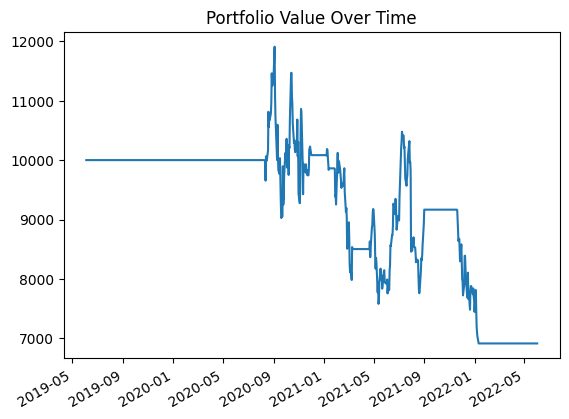

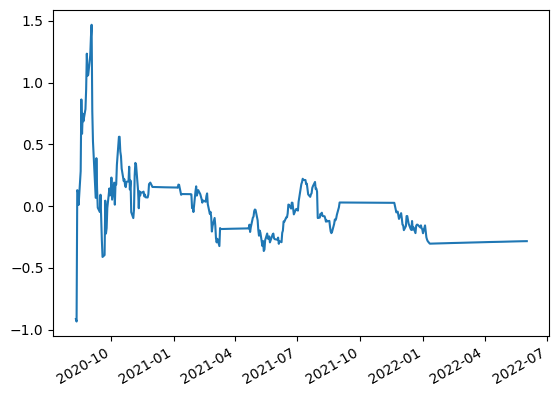

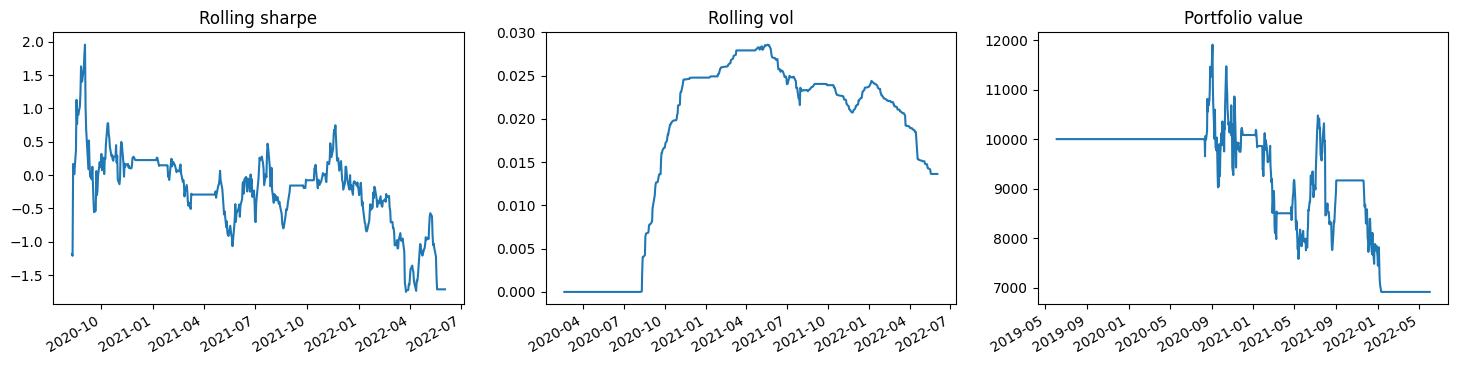

In [18]:
result_2010_onward.portfolio_value.plot(label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.show()
result_2010_onward.sharpe.plot()
result_2010_plot = show_rolling_stats(result_2010_onward, 180)